In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.special import boxcox1p 
import scipy

In [11]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Первичный анализ

In [4]:
df.shape

(1338, 7)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [6]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [7]:
df['region'].nunique()

4

In [12]:
# С категориальных в числовую 
mapping = {'yes':1, 'no':0}
df['smoker'] = df['smoker'].map(mapping)

In [13]:
mappings = {'male':1, 'female':0}
df['sex'] = df['sex'].map(mappings)

In [14]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


### Разобрались с данными, поняли что нет пропущенных значений, теперь посмотрим на распределение

<Axes: xlabel='charges', ylabel='Density'>

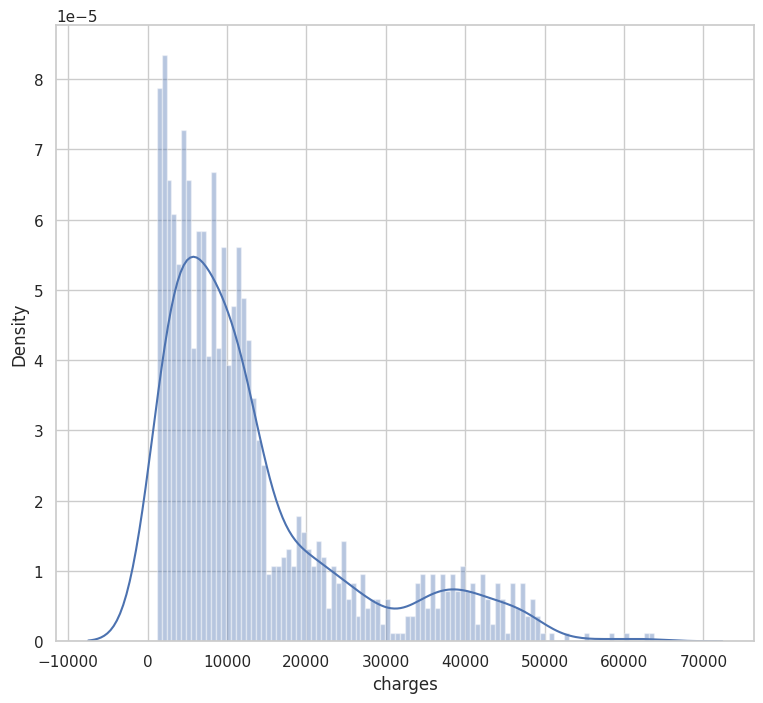

In [11]:
plt.figure(figsize = (9, 8))
sns.distplot(df['charges'], bins=100, hist_kws = {'alpha':0.4}, kde= True)

### Как видно на гистограммах, распределение исходной переменной charges сильно скошено влево (асимметрия). Такое распределение может негативно повлиять на качество регрессионных моделей, особенно линейных, но в финальном результате я отказался от этой идеи, тк результаты не удовлетворительны

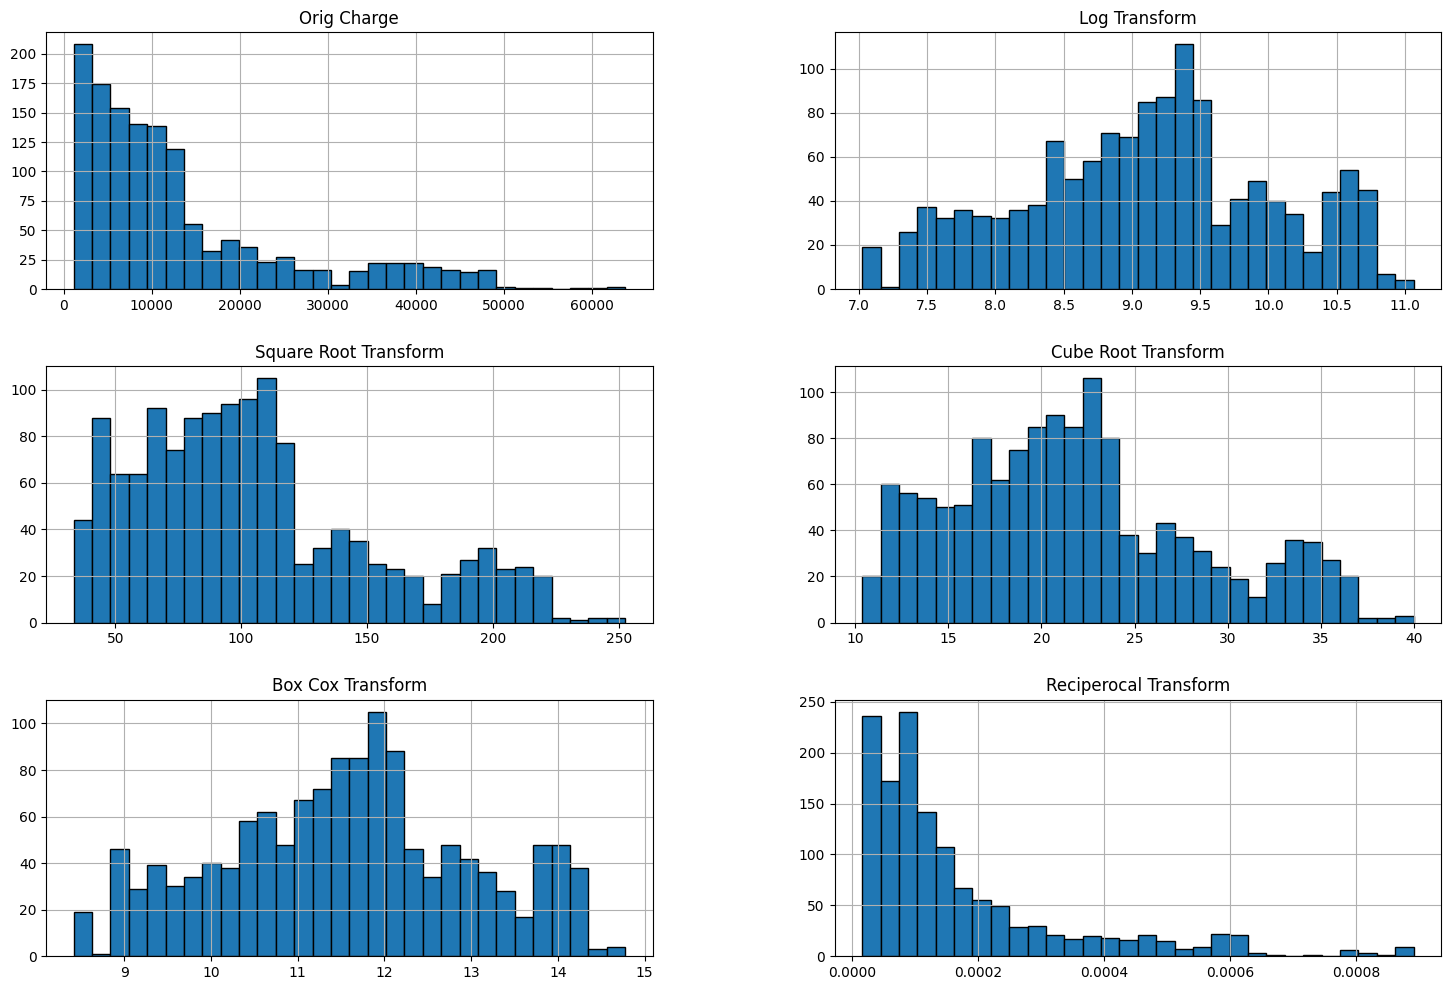

In [16]:
plt.rcParams['figure.figsize'] = (18, 12)

charges = pd.DataFrame({
    "Orig Charge": df['charges'],
    "Log Transform": np.log1p(df['charges']),
    "Square Root Transform": np.sqrt(df['charges']),
    "Cube Root Transform": np.cbrt(df['charges']),
    "Box Cox Transform": boxcox1p(df['charges'], 0.05),


    "Reciperocal Transform": 1 / (df['charges'] + 1)
})

charges.hist(bins=30, edgecolor='black')
plt.show()
    

### Преобразования log1p и boxcox хорошо справились с задачей, они значительно уменьшили асимметрию и сделали распределение целевой переменной ближе к нормальному

<Axes: >

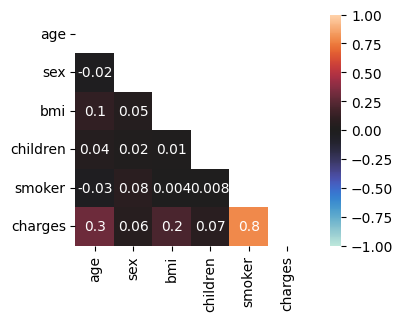

In [15]:
numeric_columns = df.select_dtypes(include=['number'])
matrix = np.triu(numeric_columns.corr())
corrmat = numeric_columns.corr()
f, ax = plt.subplots(figsize=(6, 3))
sns.heatmap(corrmat, vmin=-1, vmax=1, center=0, square=True, annot=True, fmt='.1g', mask=matrix)

### На тепловой карте видно, что признак smoker оказывает наибольшее влияние на charges, с коэффициентом корреляции около 0.8. Это означает, что курящие в среднем платят значительно больше за страховку

### Умеренная корреляция: 
#### --Чем старше человек, тем выше его страховые взносы. Это отражает рост вероятности медицинских расходов с возрастом
#### --Избыточный вес может быть связан с риском хронических заболеваний, таких как диабет и гипертония

### sex, children, region:
####  --Корреляции с целевой переменной незначительные (в пределах ±0.1), что говорит о том, что они оказывают слабое или косвенное влияние на итоговую стоимость страховки

### Сравнение моделей (оценка по кросс-валидации)

Random Forest:
  RMSE = 0.3856
  MAE  = 0.1566
  R²   = 0.8903

Gradient Boosting:
  RMSE = 0.3794
  MAE  = 0.1918
  R²   = 0.8546
  
XGB:
  RMSE = 0.3739
  MAE  = 0.1845
  R²   = 0.8534

LGBMRegressor:
  RMSE = 0.3729
  MAE  = 0.1859
  R²   = 0.8518

Random Forest показал наилучшее значение MAE и R², что указывает на устойчивые и точные предсказания.

LGBM и XGBoost немного превосходят остальные по RMSE, но имеют чуть более высокую дисперсию ошибок.

Gradient Boosting дал уверенный результат, но уступил по MAE.

Остальные модели в моем коде не удовлетворили, и я их не отобразил.

Далее, я построил графики остатков(residuals) для моделей XGBoost, Random Forest, LGBM и Gradient Boosting.
На графиках изображены остатки (предсказание - реальное значение) по оси Y, а по оси X — предсказанные значения стоимости страховки.
Красная пунктирная линия (y = 0) — это идеальный случай без ошибки.
Разброс точек вокруг неё указывает на наличие и структуру ошибок модели.

### Random Forest

модель стабильна, хорошо справляется как с низкими, так и с высокими значениями

###  XGBoost

XGB чуть более чувствителен к выбросам и дорогим клиентам

### LGBMRegressor

модель уверенно справляется со всеми диапазонами, но чуть менее устойчива, чем RF

### Gradient Boosting

GB имеет явное смещение и хуже справляется с дорогими случаями

In [23]:
!pipreqs ./ --force


INFO: Not scanning for jupyter notebooks.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
Please, verify manually the final list of requirements.txt to avoid possible dependency confusions.
INFO: Successfully saved requirements file in ./requirements.txt
